# Calculating Smiles Descriptors

In [27]:
train_len = 295246830
one_len = 1589906
zero_len = 293656924
protein_map = {'BRD4': 1, 'HSA': 2, 'sEH': 3}
vocab = {'C': 6825082866, '#': 81527490, '@': 511451694, 'H': 456489972, '=': 1406606874, 'O': 2554179786,
         'N': 2469595230, 'c': 12257477022, '-': 438483636, '.': 216945504, 'l': 491088828, 'B': 123330132,
         'r': 121915914, 'n': 1997759694, 'D': 295246830, 'y': 295246830, 'o': 67918650, 's': 156618468,
         'S': 90662574, 'F': 492710238, '+': 65206260, 'i': 1414026, '/': 11547096, 'I': 23972994}

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.sql import functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import LongType, IntegerType, StructType, StructField, ArrayType, DoubleType, StringType
from pyspark.ml.linalg import SparseVector

from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, StringIndexerModel, OneHotEncoderModel
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

import pandas as pd
import numpy as np
import joblib

from xgboost.spark import SparkXGBClassifier

from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

from concurrent.futures import ThreadPoolExecutor
from joblib import Parallel, delayed
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, rdmolops, AllChem, rdchem, rdEHTTools, rdMolDescriptors
from tqdm.auto import tqdm
from padelpy import from_smiles
from IPython.display import display, HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [2]:
# # for 256 Gb and 64 Cores
# spark = (
#     SparkSession
#     .builder
#     .appName("leash belka3")
#     .config("spark.driver.memory", "48g")  # Increased driver memory
#     .config("spark.executor.memory", "48g")  # Increased executor memory
#     .config("spark.executor.instances", "16")  # 16 executors
#     .config("spark.executor.cores", "4")  # 4 cores per executor
#     .config("spark.driver.maxResultSize", "4g")  # Driver result size limit
#     .config("spark.local.dir", "temp")  # Specify a directory with enough space
#     # .config("spark.local.dir", "/scratch/23m1521/temp")  # Specify a directory with enough space
#     .config("spark.shuffle.file.buffer", "128k")  # Shuffle buffer size
#     .config("spark.memory.fraction", "0.8")  # Memory fraction for tasks
#     .config("spark.shuffle.memoryFraction", "0.6")  # Shuffle memory fraction
#     .config("spark.executor.javaOptions", "-Xmx48g")  # JVM heap size for executors
#     .master("local[64]")  # Use all 64 cores on the machine
#     .getOrCreate()
# )

# spark
spark = (
    SparkSession
    .builder
    .appName("leash belka34")
    .config("spark.driver.memory", "64g")  # Increased driver memory for large jobs
    .config("spark.executor.memory", "64g")  # Increased executor memory
    .config("spark.executor.instances", "32")  # 32 executors
    .config("spark.executor.cores", "2")  # 2 cores per executor
    .config("spark.driver.maxResultSize", "8g")  # Driver result size limit
    .config("spark.local.dir", "temp")  # Ensure high-speed storage
    .config("spark.shuffle.file.buffer", "1024k")  # Larger shuffle buffer for better IO
    .config("spark.memory.fraction", "0.85")  # Increased memory for tasks
    .config("spark.shuffle.memoryFraction", "0.7")  # Increased shuffle memory
    .config("spark.executor.javaOptions", "-Xmx64g")  # JVM heap size for executors
    .master("local[*]")  # Use all 64 cores on the machine
    .getOrCreate()
)
spark

# SparkSession for 128 GB RAM and 64 cores
# spark = (
#     SparkSession
#     .builder
#     .appName("Optimized Spark for 128GB RAM and 64 Cores")
#     .config("spark.driver.memory", "64g")  # 64GB for driver memory
#     .config("spark.executor.memory", "64g")  # 64GB for executor memory
#     .config("spark.executor.instances", "16")  # 16 executors
#     .config("spark.executor.cores", "4")  # 4 cores per executor (total = 64 cores)
#     .config("spark.driver.maxResultSize", "8g")  # Driver result size limit
#     .config("spark.local.dir", "temp")  # Temp directory with enough space
#     .config("spark.shuffle.file.buffer", "512k")  # Increased shuffle buffer size
#     .config("spark.memory.fraction", "0.8")  # Memory fraction for tasks
#     .config("spark.shuffle.memoryFraction", "0.6")  # Shuffle memory fraction
#     .config("spark.executor.javaOptions", "-Xmx64g")  # JVM heap size for executors
#     .master("local[64]")  # Use all 64 cores on the machine
#     .getOrCreate()
# )

# spark

# SynapseML 
# spark = (
#     SparkSession
#     .builder
#     .appName("leash belka3")
#     .config("spark.driver.memory", "48g")  # Increased driver memory
#     .config("spark.executor.memory", "48g")  # Increased executor memory
#     .config("spark.executor.instances", "16")  # 16 executors
#     .config("spark.executor.cores", "4")  # 4 cores per executor
#     .config("spark.driver.maxResultSize", "4g")  # Driver result size limit
#     .config("spark.local.dir", "temp")  # Specify a directory with enough space
#     .config("spark.shuffle.file.buffer", "128k")  # Shuffle buffer size
#     .config("spark.memory.fraction", "0.8")  # Memory fraction for tasks
#     .config("spark.shuffle.memoryFraction", "0.6")  # Shuffle memory fraction
#     .config("spark.executor.javaOptions", "-Xmx48g")  # JVM heap size for executors
#     .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:1.0.8")
#     .config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven")
#     .master("local[64]")  # Use all 64 cores on the machine
#     .getOrCreate()
# )

# spark

# spark = (
#     SparkSession
#     .builder
#     .appName("leash belka3")
#     .config("spark.driver.memory", "64g")  # Increased driver memory
#     .config("spark.executor.memory", "64g")  # Increased executor memory
#     .config("spark.executor.instances", "8")  # Reduced number of executors
#     .config("spark.executor.cores", "8")  # Increased cores per executor
#     .config("spark.driver.maxResultSize", "4g")  # Driver result size limit
#     .config("spark.local.dir", "temp")  # Specify a directory with enough space
#     .config("spark.shuffle.file.buffer", "128k")  # Shuffle buffer size
#     .config("spark.memory.fraction", "0.8")  # Memory fraction for tasks
#     .config("spark.shuffle.memoryFraction", "0.7")  # Shuffle memory fraction
#     .config("spark.executor.javaOptions", "-Xmx64g")  # JVM heap size for executors
#     .config("spark.sql.shuffle.partitions", "1000")  # Increase shuffle partitions
#     .config("spark.ui.enabled", "true")  # Enable Spark UI
#     .master("local[8]")  # Reduced number of cores for local mode
#     .getOrCreate()
# )

# spark


24/12/31 06:01:42 WARN Utils: Your hostname, kanjur resolves to a loopback address: 127.0.1.1; using 10.119.2.14 instead (on interface eno3)
24/12/31 06:01:42 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/31 06:01:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/12/31 06:01:43 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 37738)
Traceback (most recent call last):
  File "/home/23m1521/.conda/envs/cuda_env2/lib/python3.12/socketserver.py", line 318, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/home/23m1521/.conda/envs/cuda_env2/lib/python3.12/socketserver.py", line 349, in process_request
    self.finish_request(request, client_address)
  File "/home/23m1521/.conda/envs/cuda_env2/lib/python3.12/socketserver.py", line 362, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/home/23m1521/.conda/envs/cuda_env2/lib/python3.12/socketserver.py", line 761, in __init__
    self.handle()
  File "/home/23m1521/.conda/envs/cuda_env2/lib/python3.12/site-packages/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/home/23m1521/.conda/envs/cuda_env2/lib/python3.12/site-packages/pyspark/accumulators.py", line 26

In [3]:
full_df_features = spark.read.format('parquet').load('train_descriptors.parquet')

In [4]:
full_df_features.show()

24/12/31 06:01:48 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
                                                                                

+---------+-----+-----------------+--------------+-----------------+-----------------+---------------------+--------------+-----------------+----------------+-------------------+-----------------+--------------------+---------------------+---------------------+------------------+------------+-------------+--------------------+-----------------------+----------------------+------------------+-----------------+----------------------+---------------------+---------+--------------+------------------+--------+---------------------+--------------+-----------------+----------------+------------------+-----------------+--------------------+---------------------+---------------------+------------------+------------+-------------+--------------------+-----------------------+----------------------+------------------+------------------+----------------------+---------------------+------------------+--------------+-------------------+------------------+---------------------+--------------+---------

In [5]:
def protein_onehot_TO_Array(df):
    # UDF to convert SparseVector to list
    def sparse_to_list(vec):
        return vec.toArray().tolist()

    sparse_to_list_udf = udf(sparse_to_list, ArrayType(DoubleType()))
    df = df.withColumn("protein_array", sparse_to_list_udf(df["protein_onehot"]))
    for i in range(len(df.select("protein_array").first()["protein_array"])):
        df = df.withColumn(f"protein_{i}", df["protein_array"][i])
    df = df.drop("protein_array")
    return df

In [6]:
full_df_features = protein_onehot_TO_Array(full_df_features)
full_df_features.show()

[Stage 3:>                                                          (0 + 1) / 1]

+---------+-----+-----------------+--------------+-----------------+-----------------+---------------------+--------------+-----------------+----------------+-------------------+-----------------+--------------------+---------------------+---------------------+------------------+------------+-------------+--------------------+-----------------------+----------------------+------------------+-----------------+----------------------+---------------------+---------+--------------+------------------+--------+---------------------+--------------+-----------------+----------------+------------------+-----------------+--------------------+---------------------+---------------------+------------------+------------+-------------+--------------------+-----------------------+----------------------+------------------+------------------+----------------------+---------------------+------------------+--------------+-------------------+------------------+---------------------+--------------+---------

In [7]:
features_cols = full_df_features.columns[2:-2]
features_cols

['bb1_MolWt',
 'bb1_ExactMolWt',
 'bb1_MolLogP',
 'bb1_TPSA',
 'bb1_NumRotatableBonds',
 'bb1_NumHDonors',
 'bb1_NumHAcceptors',
 'bb1_FormalCharge',
 'bb1_FractionCSP3',
 'bb1_NumHeavyAtoms',
 'bb1_NumAromaticRings',
 'bb1_NumAliphaticRings',
 'bb1_NumSaturatedRings',
 'bb1_NumHeteroatoms',
 'bb1_NumRings',
 'bb1_MolVolume',
 'bb1_RadiusOfGyration',
 'bb1_InertialShapeFactor',
 'bb1_AromaticProportion',
 'bb1_HBondPotential',
 'bb1_Lipophilicity',
 'bb1_ChargeDistribution',
 'bb1_ElectroNegativity',
 'bb2_MolWt',
 'bb2_ExactMolWt',
 'bb2_MolLogP',
 'bb2_TPSA',
 'bb2_NumRotatableBonds',
 'bb2_NumHDonors',
 'bb2_NumHAcceptors',
 'bb2_FormalCharge',
 'bb2_FractionCSP3',
 'bb2_NumHeavyAtoms',
 'bb2_NumAromaticRings',
 'bb2_NumAliphaticRings',
 'bb2_NumSaturatedRings',
 'bb2_NumHeteroatoms',
 'bb2_NumRings',
 'bb2_MolVolume',
 'bb2_RadiusOfGyration',
 'bb2_InertialShapeFactor',
 'bb2_AromaticProportion',
 'bb2_HBondPotential',
 'bb2_Lipophilicity',
 'bb2_ChargeDistribution',
 'bb2_ElectroN

In [28]:
joblib.dump(features_cols, 'features_cols_list.joblib')

['features_cols_list.joblib']

24/12/31 21:25:57 WARN JavaUtils: Attempt to delete using native Unix OS command failed for path = /home/23m1521/ashish/kaggle/temp/blockmgr-57069b2f-39c5-4d76-bb04-a2fa4cf0658d. Falling back to Java IO way
java.io.IOException: Failed to delete: /home/23m1521/ashish/kaggle/temp/blockmgr-57069b2f-39c5-4d76-bb04-a2fa4cf0658d
	at org.apache.spark.network.util.JavaUtils.deleteRecursivelyUsingUnixNative(JavaUtils.java:174)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:109)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:90)
	at org.apache.spark.util.SparkFileUtils.deleteRecursively(SparkFileUtils.scala:121)
	at org.apache.spark.util.SparkFileUtils.deleteRecursively$(SparkFileUtils.scala:120)
	at org.apache.spark.util.Utils$.deleteRecursively(Utils.scala:1126)
	at org.apache.spark.storage.DiskBlockManager.$anonfun$doStop$1(DiskBlockManager.scala:368)
	at org.apache.spark.storage.DiskBlockManager.$anonfun$doStop$1$adapted(DiskBlockMa

In [8]:
vectorAssembler = VectorAssembler(inputCols=features_cols, outputCol='vectors')
full_df_vectors = vectorAssembler.transform(full_df_features).select('id', 'vectors', 'binds', 'protein_0', 'protein_1')
full_df_vectors.show()

[Stage 4:>                                                          (0 + 1) / 1]

+---------+--------------------+-----+---------+---------+
|       id|             vectors|binds|protein_0|protein_1|
+---------+--------------------+-----+---------+---------+
|193986560|[360.369000000000...|    0|      0.0|      0.0|
|193986561|[360.369000000000...|    0|      1.0|      0.0|
|193986562|[360.369000000000...|    0|      0.0|      1.0|
|193986563|[360.369000000000...|    0|      0.0|      0.0|
|193986564|[360.369000000000...|    0|      1.0|      0.0|
|193986565|[360.369000000000...|    0|      0.0|      1.0|
|193986566|[360.369000000000...|    0|      0.0|      0.0|
|193986567|[360.369000000000...|    0|      1.0|      0.0|
|193986568|[360.369000000000...|    0|      0.0|      1.0|
|193986569|[360.369000000000...|    0|      0.0|      0.0|
|193986570|[360.369000000000...|    0|      1.0|      0.0|
|193986571|[360.369000000000...|    0|      0.0|      1.0|
|193986572|[360.369000000000...|    0|      0.0|      0.0|
|193986573|[360.369000000000...|    0|      1.0|      0.

In [9]:
full_df_vectors = full_df_vectors.withColumn(
    "protein",
    when((full_df_vectors.protein_0 == 0) & (full_df_vectors.protein_1 == 0), 2)  # Both protein_0 and protein_1 are zero
    .when(full_df_vectors.protein_0 == 1, 0)                         # protein_0 is non-zero
    .when(full_df_vectors.protein_1 == 1, 1)                         # protein_1 is non-zero
    .otherwise(None)                                                 # For other cases, if any
)

full_df_vectors.show()

[Stage 5:>                                                          (0 + 1) / 1]

+---------+--------------------+-----+---------+---------+-------+
|       id|             vectors|binds|protein_0|protein_1|protein|
+---------+--------------------+-----+---------+---------+-------+
|193986560|[360.369000000000...|    0|      0.0|      0.0|      2|
|193986561|[360.369000000000...|    0|      1.0|      0.0|      0|
|193986562|[360.369000000000...|    0|      0.0|      1.0|      1|
|193986563|[360.369000000000...|    0|      0.0|      0.0|      2|
|193986564|[360.369000000000...|    0|      1.0|      0.0|      0|
|193986565|[360.369000000000...|    0|      0.0|      1.0|      1|
|193986566|[360.369000000000...|    0|      0.0|      0.0|      2|
|193986567|[360.369000000000...|    0|      1.0|      0.0|      0|
|193986568|[360.369000000000...|    0|      0.0|      1.0|      1|
|193986569|[360.369000000000...|    0|      0.0|      0.0|      2|
|193986570|[360.369000000000...|    0|      1.0|      0.0|      0|
|193986571|[360.369000000000...|    0|      0.0|      1.0|    

In [21]:
full_df_vectors.groupBy("protein").count().collect()

[Row(protein=1, count=98415610),
 Row(protein=2, count=98415610),
 Row(protein=0, count=98415610)]

In [28]:
print(full_df_vectors.groupBy("binds").count().collect())

[Stage 45:===================================>                   (46 + 25) / 71]

[Row(binds=0, count=293656924), Row(binds=1, count=1589906)]


In [17]:
293656924*0.005150, 1589906*1

(1512333.1586, 1589906)

In [19]:
df_vectors = full_df_vectors.sampleBy('binds', fractions={0: 0.005150, 1: 1.0}, seed=42)
print(df_vectors.groupBy("binds").count().collect())
print(df_vectors.groupBy("protein").count().collect())
print(df_vectors.count())
df_vectors.show()

[Row(binds=0, count=1513713), Row(binds=1, count=1589906)]


[Row(protein=1, count=912994), Row(protein=2, count=1227916), Row(protein=0, count=962709)]
3103619
+---------+--------------------+-----+---------+---------+-------+
|       id|             vectors|binds|protein_0|protein_1|protein|
+---------+--------------------+-----+---------+---------+-------+
|193986815|[360.369000000000...|    0|      0.0|      0.0|      2|
|193986873|(94,[0,1,2,3,4,5,...|    0|      1.0|      0.0|      0|
|193987759|[360.369000000000...|    0|      0.0|      1.0|      1|
|193987768|[360.369000000000...|    0|      0.0|      1.0|      1|
|193987965|[360.369000000000...|    0|      1.0|      0.0|      0|
|193988203|[360.369000000000...|    0|      0.0|      1.0|      1|
|193988251|[360.369000000000...|    0|      0.0|      1.0|      1|
|193988253|[360.369000000000...|    0|      1.0|      0.0|      0|
|193988384|(94,[0,1,2,3,4,5,...|    0|      0.0|      0.0|      2|
|193988659|[360.369000000000...|    0|      0.0|      1.0|      1|
|193988937|(94,[0,1,2,3,4,5,.

In [15]:
from pyspark.sql import functions as F

# For protein_0 = 1
result_protein_0_1 = full_df_vectors.filter(full_df_vectors.protein_0 == 1) \
                       .groupBy("binds") \
                       .agg(F.count("*").alias("binds_count"))

# For protein_2 = 1
result_protein_1_1 = full_df_vectors.filter(full_df_vectors.protein_1 == 1) \
                       .groupBy("binds") \
                       .agg(F.count("*").alias("binds_count"))

# For protein_0 = 0 and protein_1 = 0
result_protein_0_0_and_protein_1_0 = full_df_vectors.filter((full_df_vectors.protein_0 == 0) & (full_df_vectors.protein_1 == 0)) \
                                      .groupBy("binds") \
                                      .agg(F.count("*").alias("binds_count"))

# Show results
result_protein_0_1.show()
result_protein_1_1.show()
result_protein_0_0_and_protein_1_0.show()

+-----+-----------+
|binds|binds_count|
+-----+-----------+
|    0|   97958646|
|    1|     456964|
+-----+-----------+



+-----+-----------+
|binds|binds_count|
+-----+-----------+
|    0|   98007200|
|    1|     408410|
+-----+-----------+



[Stage 19:=======================================================>(70 + 1) / 71]

+-----+-----------+
|binds|binds_count|
+-----+-----------+
|    0|   97691078|
|    1|     724532|
+-----+-----------+



In [46]:
df_vectors.show()

[Stage 63:>                                                         (0 + 1) / 1]

+---------+--------------------+-----+---------+---------+-------+
|       id|             vectors|binds|protein_0|protein_1|protein|
+---------+--------------------+-----+---------+---------+-------+
|193996160|(94,[0,1,2,3,4,5,...|    0|      0.0|      0.0|      2|
|193997410|[360.369000000000...|    0|      0.0|      1.0|      1|
|194001563|[360.369000000000...|    0|      0.0|      0.0|      2|
|194021946|(94,[0,1,2,3,4,5,...|    0|      1.0|      0.0|      0|
|194027118|(94,[0,1,2,3,4,5,...|    0|      1.0|      0.0|      0|
|194027972|[360.369000000000...|    0|      0.0|      0.0|      2|
|194030593|[360.369000000000...|    1|      0.0|      1.0|      1|
|194030875|[360.369000000000...|    0|      0.0|      1.0|      1|
|194032258|[360.369000000000...|    0|      0.0|      1.0|      1|
|194033516|[360.369000000000...|    0|      0.0|      0.0|      2|
|194033893|[360.369000000000...|    0|      0.0|      1.0|      1|
|194034475|[360.369000000000...|    1|      0.0|      1.0|    

In [14]:
df_vectors.groupBy("binds").count().collect()

[Row(binds=0, count=5916), Row(binds=1, count=37)]

In [13]:
df_vectors.count()

5953

In [8]:
full_df_vectors = full_df_vectors.repartition(200)

//////////////////////////////////////////////////////////////////////////////////

In [ ]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=2, seed=42, featuresCol='vectors', predictionCol="cluster")
model = kmeans.fit(full_df_vectors)

# Get predictions
predictions = model.transform(full_df_vectors)

# Show clusters
predictions.select("cluster", "binds").show()

In [ ]:
# Save the model to a directory
model.save("KMeans_model")

# To load the model later
# from pyspark.ml.clustering import KMeansModel
# loaded_model = KMeansModel.load("path_to_save_model")

In [7]:
from pyspark.ml.classification import RandomForestClassifier

rf_model = RandomForestClassifier(featuresCol="vectors", labelCol="binds", numTrees=100, probabilityCol="probability")
rf_model = rf_model.fit(full_df_vectors)
rf_model.save("rf_model")

predictions = rf_model.transform(full_df_vectors)

predictions.select("id", "binds", "prediction", "probability").show(truncate=False)

24/12/30 09:11:07 WARN MemoryStore: Not enough space to cache rdd_38_54 in memory! (computed 582.2 MiB so far)
24/12/30 09:11:07 WARN BlockManager: Persisting block rdd_38_54 to disk instead.
24/12/30 09:11:07 WARN MemoryStore: Not enough space to cache rdd_38_3 in memory! (computed 582.2 MiB so far)
24/12/30 09:11:07 WARN BlockManager: Persisting block rdd_38_3 to disk instead.
24/12/30 09:11:07 WARN MemoryStore: Not enough space to cache rdd_38_28 in memory! (computed 582.2 MiB so far)
24/12/30 09:11:07 WARN BlockManager: Persisting block rdd_38_28 to disk instead.
24/12/30 09:11:07 WARN MemoryStore: Not enough space to cache rdd_38_61 in memory! (computed 582.2 MiB so far)
24/12/30 09:11:07 WARN BlockManager: Persisting block rdd_38_61 to disk instead.
24/12/30 09:11:07 WARN MemoryStore: Not enough space to cache rdd_38_24 in memory! (computed 582.2 MiB so far)
24/12/30 09:11:07 WARN BlockManager: Persisting block rdd_38_24 to disk instead.
24/12/30 09:11:07 WARN MemoryStore: Not en

[905.927s][warning][gc,alloc] Executor task launch worker for task 55.0 in stage 10.0 (TID 344): Retried waiting for GCLocker too often allocating 101188 words


24/12/30 09:21:20 WARN MemoryStore: Not enough space to cache rdd_38_2 in memory! (computed 162.4 MiB so far)
24/12/30 09:21:20 WARN MemoryStore: Not enough space to cache rdd_38_22 in memory! (computed 162.4 MiB so far)
24/12/30 09:21:20 WARN MemoryStore: Not enough space to cache rdd_38_65 in memory! (computed 162.4 MiB so far)
24/12/30 09:21:20 WARN MemoryStore: Not enough space to cache rdd_38_47 in memory! (computed 162.4 MiB so far)
24/12/30 09:21:20 WARN MemoryStore: Not enough space to cache rdd_38_5 in memory! (computed 162.4 MiB so far)
24/12/30 09:21:20 WARN MemoryStore: Not enough space to cache rdd_38_59 in memory! (computed 162.4 MiB so far)
24/12/30 09:21:20 WARN MemoryStore: Not enough space to cache rdd_38_61 in memory! (computed 162.4 MiB so far)
24/12/30 09:21:20 WARN MemoryStore: Not enough space to cache rdd_38_52 in memory! (computed 162.4 MiB so far)
24/12/30 09:21:20 WARN MemoryStore: Not enough space to cache rdd_38_32 in memory! (computed 162.4 MiB so far)
24/

+---------+-----+----------+-----------------------------------------+
|id       |binds|prediction|probability                              |
+---------+-----+----------+-----------------------------------------+
|193986560|0    |0.0       |[0.9946306076488763,0.005369392351123681]|
|193986561|0    |0.0       |[0.9946306076488763,0.005369392351123681]|
|193986562|0    |0.0       |[0.9946306076488763,0.005369392351123681]|
|193986563|0    |0.0       |[0.9946306076488763,0.005369392351123681]|
|193986564|0    |0.0       |[0.9946306076488763,0.005369392351123681]|
|193986565|0    |0.0       |[0.9946306076488763,0.005369392351123681]|
|193986566|0    |0.0       |[0.9946306076488763,0.005369392351123681]|
|193986567|0    |0.0       |[0.9946306076488763,0.005369392351123681]|
|193986568|0    |0.0       |[0.9946306076488763,0.005369392351123681]|
|193986569|0    |0.0       |[0.9946306076488763,0.005369392351123681]|
|193986570|0    |0.0       |[0.9946306076488763,0.005369392351123681]|
|19398

In [ ]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Define the classifier
gbt = GBTClassifier(featuresCol="vectors", labelCol="binds")

# Define the parameter grid with higher maxIter values
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [3, 5, 7])
             .addGrid(gbt.maxIter, [50, 100, 200])  # Higher values for maxIter
             .addGrid(gbt.stepSize, [0.05, 0.1, 0.2])
             .build())

# Define the evaluator using PR curve
evaluator = BinaryClassificationEvaluator(labelCol="binds", metricName="areaUnderPR")

# Define the CrossValidator
cv = CrossValidator(estimator=gbt,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=5)  # 3-fold cross-validation

# Fit the CrossValidator
cv_model = cv.fit(full_df_vectors)

# Get the best model
best_model = cv_model.bestModel


# Save the best model
best_model.selectave("best_gbt_model")

# Make predictions
predictions = best_model.transform(full_df_vectors)

# Show predictions
predictions.select("id", "binds", "prediction", "probability").show(truncate=False)


In [9]:
from pyspark.ml.classification import GBTClassifier

gbt_model = GBTClassifier(
    featuresCol="vectors", 
    labelCol="binds", 
    maxMemoryInMB=int(1024*3),
    cacheNodeIds=True,
    maxIter=100,
    weightCol="sample_weights",
    minInstancesPerNode=int(450000)
)

gbt_model = gbt_model.fit(full_df_vectors)
gbt_model.save("gbt_model")

predictions = gbt_model.transform(full_df_vectors)

predictions.select("id", "binds", "prediction", "probability").show(truncate=False)

Exception in thread "refresh progress" java.lang.OutOfMemoryError: Java heap space
24/12/30 19:41:52 ERROR Utils: uncaught error in thread Spark Context Cleaner, stopping SparkContext
java.lang.OutOfMemoryError: Java heap space
24/12/30 19:41:52 ERROR Utils: uncaught error in thread spark-listener-group-appStatus, stopping SparkContext
java.lang.OutOfMemoryError: Java heap space
24/12/30 19:41:52 ERROR Utils: Uncaught exception in thread executor-heartbeater
java.lang.OutOfMemoryError: Java heap space
24/12/30 19:41:52 ERROR Executor: Exception in task 27.0 in stage 5.0 (TID 101)
java.lang.OutOfMemoryError: Java heap space
24/12/30 19:41:52 ERROR Executor: Exception in task 53.0 in stage 5.0 (TID 127)
java.lang.OutOfMemoryError: Java heap space
24/12/30 19:41:52 ERROR Executor: Exception in task 35.0 in stage 5.0 (TID 109)
java.lang.OutOfMemoryError: Java heap space
24/12/30 19:41:52 ERROR Executor: Exception in task 50.0 in stage 5.0 (TID 124)
java.lang.OutOfMemoryError: Java heap spa

ConnectionRefusedError: [Errno 111] Connection refused

In [ ]:
predictions.show()

In [20]:
from pyspark.ml.classification import GBTClassifier

gbt_model = GBTClassifier(
    featuresCol="vectors", 
    labelCol="binds", 
    maxMemoryInMB=int(1024*3),
    cacheNodeIds=True,
    maxIter=100,
    # weightCol="sample_weights",
    # minInstancesPerNode=int(450000)
).setProbabilityCol('probability')

gbt_model = gbt_model.fit(df_vectors)

In [21]:
gbt_model.save("gbt_model3")

predictions = gbt_model.transform(df_vectors)
full_predictions = gbt_model.transform(full_df_vectors)

predictions.select("id", "binds", "prediction", "probability").show(truncate=False)

+---------+-----+----------+----------------------------------------+
|id       |binds|prediction|probability                             |
+---------+-----+----------+----------------------------------------+
|193986815|0    |0.0       |[0.8133219503431156,0.1866780496568844] |
|193986873|0    |0.0       |[0.872947232222844,0.12705276777715602] |
|193987759|0    |0.0       |[0.7165152364549165,0.28348476354508345]|
|193987768|0    |0.0       |[0.6607212863838782,0.33927871361612183]|
|193987965|0    |0.0       |[0.8121812757411876,0.1878187242588124] |
|193988203|0    |0.0       |[0.8965174540433272,0.10348254595667283]|
|193988251|0    |0.0       |[0.9312742039851282,0.06872579601487183]|
|193988253|0    |0.0       |[0.8488230936180665,0.15117690638193348]|
|193988384|0    |0.0       |[0.9135776510482096,0.08642234895179035]|
|193988659|0    |0.0       |[0.8065411722037131,0.19345882779628687]|
|193988937|0    |0.0       |[0.6584847827516036,0.3415152172483964] |
|193989118|0    |0.0

24/12/31 06:33:44 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


In [22]:
full_predictions.select("id", "binds", "prediction", "probability").show(truncate=False)

+---------+-----+----------+----------------------------------------+
|id       |binds|prediction|probability                             |
+---------+-----+----------+----------------------------------------+
|193986560|0    |1.0       |[0.3334551900609396,0.6665448099390604] |
|193986561|0    |0.0       |[0.7420192376014105,0.25798076239858947]|
|193986562|0    |0.0       |[0.5319507848327735,0.46804921516722653]|
|193986563|0    |1.0       |[0.34336952174675633,0.6566304782532437]|
|193986564|0    |0.0       |[0.7420192376014105,0.25798076239858947]|
|193986565|0    |0.0       |[0.5319507848327735,0.46804921516722653]|
|193986566|0    |1.0       |[0.34336952174675633,0.6566304782532437]|
|193986567|0    |0.0       |[0.6202850712030866,0.3797149287969134] |
|193986568|0    |1.0       |[0.3730917603876306,0.6269082396123694] |
|193986569|0    |1.0       |[0.31179399421152254,0.6882060057884775]|
|193986570|0    |0.0       |[0.6109839743013769,0.38901602569862315]|
|193986571|0    |1.0

In [23]:
# Calculate PR AUC (Area Under Precision-Recall Curve)
pr_auc_evaluator = BinaryClassificationEvaluator(labelCol="binds", rawPredictionCol="prediction", 
                                                 metricName="areaUnderPR")
pr_auc = pr_auc_evaluator.evaluate(predictions)
print(f"PR AUC (approx MAP): {pr_auc}")

pr_auc = pr_auc_evaluator.evaluate(full_predictions)
print(f"PR AUC (approx MAP): {pr_auc}")

PR AUC (approx MAP): 0.8689798996805755


PR AUC (approx MAP): 0.04196810346034951


In [14]:
# Calculate PR AUC (Area Under Precision-Recall Curve)
pr_auc_evaluator = BinaryClassificationEvaluator(labelCol="binds", rawPredictionCol="prediction", 
                                                 metricName="areaUnderPR")
pr_auc = pr_auc_evaluator.evaluate(predictions)
print(f"PR AUC (approx MAP): {pr_auc}")

pr_auc = pr_auc_evaluator.evaluate(full_predictions)
print(f"PR AUC (approx MAP): {pr_auc}")

PR AUC (approx MAP): 0.8706980740946578


PR AUC (approx MAP): 0.04441751007378148


In [15]:
# Calculate AUC (Area Under ROC)
auc_evaluator = BinaryClassificationEvaluator(labelCol="binds", rawPredictionCol="prediction", 
                                              metricName="areaUnderROC")
auc = auc_evaluator.evaluate(predictions)
print(f"AUC: {auc}")

auc = auc_evaluator.evaluate(full_predictions)
print(f"AUC: {auc}")

AUC: 0.8707083120361421


AUC: 0.8673478850352395


1318935 27747878 265909046 270971


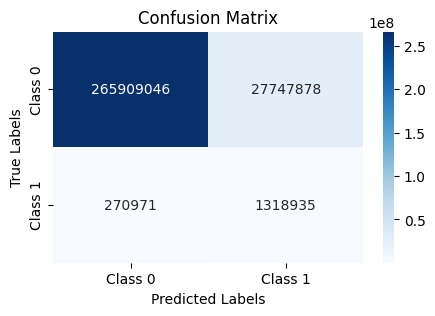

In [24]:
TP = full_predictions.filter((col("binds") == 1) & (col("prediction") == 1)).count()
FP = full_predictions.filter((col("binds") == 0) & (col("prediction") == 1)).count()
TN = full_predictions.filter((col("binds") == 0) & (col("prediction") == 0)).count()
FN = full_predictions.filter((col("binds") == 1) & (col("prediction") == 0)).count()

import seaborn as sns
import matplotlib.pyplot as plt

print(TP, FP, TN, FN)
confusion_matrix = [
    [TN, FP],
    [FN, TP]
]

plt.figure(figsize=(5, 3))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [25]:
# Calculate Precision and Recall
precision = TP / (TP + FP) if (TP + FP) > 0 else 0  # Precision = TP / (TP + FP)
recall = TP / (TP + FN) if (TP + FN) > 0 else 0      # Recall = TP / (TP + FN)

precision, recall

(0.04537597568746185, 0.8295679115620672)